## Injected Sources Test

This notebook analyses the results of XID+ when run on fake sources injected into the lofar map and convolved with the dirty beam. The results can be compared with running XID+ on the same location when the source is not injected to see what results XID+ returns on a fake location

In [97]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import pymoc
import glob
from time import sleep
import os
from astropy.nddata.utils import Cutout2D
from astropy.convolution import Gaussian2DKernel
#import herschelhelp.cutouts_server as ctts
import scipy

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
#from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp import image_plotting,utils
import pyvo as vo
import glob

import copy
from healpy import pixelfunc

In [100]:
def get_HEALPix_pixels(order,ra,dec,unique=True):


    """Work out what HEALPix a source is in

    :param order: order of HEALPix
    :param ra: Right Ascension
    :param dec: Declination
    :param unique: if unique is true, removes duplicate pixels
    :return: list of HEALPix pixels :rtype:
    """
    HPX_D2R=np.pi/180.0
    #Convert catalogue to polar co-ords in radians
    phi = ra*HPX_D2R
    theta = np.pi/2.0 - dec*HPX_D2R
    #calculate what pixel each object is in
    ipix = pixelfunc.ang2pix(2**order, theta, phi, nest=True)
    #return unique pixels (i.e. remove duplicates)
    if unique is True:
        return np.unique(ipix)
    else:
        return ipix

def create_MOC_from_map(good,header,wcs):
    """Generate MOC from map


    :param good: boolean array associated with map
    :param wcs: wcs information
    :return: MOC :rtype: pymoc.MOC
    """
    x_pix,y_pix=np.meshgrid(np.arange(0,header['NAXIS1']),np.arange(0,header['NAXIS2']))
    ra,dec= wcs.wcs_pix2world(x_pix,y_pix,0)

    pixels=get_HEALPix_pixels(15,ra[good],dec[good])
    map_moc=pymoc.MOC()
    map_moc.add(15,pixels)
    return map_moc

In [101]:
fname = '../data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0].astype('f4')*1000 #convert to mJy
hdulist.close()
radim_header['NAXIS']=2
radim_header['WCSAXES']=2



good = ~np.isnan(radim_data)
radim_moc = create_MOC_from_map(good,radim_header,radim_wcs)

In [31]:
injected_cat = Table.read('data/injected_source_cat.fits')
print(len(injected_cat))
ids_new = np.arange(0,len(injected_cat),1)
col_id = Column(name='Source_Name',data=ids_new.astype(str))
injected_cat.add_column(col_id)

injected_cat[0]

10000


RA_injected,DEC_injected,flux_injected,Source_Name
float64,float64,float64,str21
241.40452087640338,55.58269595210964,-1.0,0


In [103]:
file_list = glob.glob('data/xidplus_results/random_positions/*/*.fits')

for n,file in enumerate(file_list):
    #prior,posterior = xidplus.load(file)
    #cat_tmp = xidplus.catalogue.create_LOFAR_cat(posterior,prior[0])
    if (n%500)==0:
        print(n)
    if n==0:
        catalogue = Table.read(file)
    else:
        cat_tmp = Table.read(file)
        catalogue = vstack([catalogue,cat_tmp])
        
catalogue.rename_column('help_id','Source_Name')
catalogue_random_position = join(catalogue,injected_cat,keys='Source_Name',)

from astropy.io import registry
from astropy.table.info import serialize_method_as
with serialize_method_as(catalogue_random_position, None):
            registry.write(catalogue_random_position,'data/xidplus_results/random_positions/random_positions_results_cat.fits',format='fits',overwrite=True)

6
2
2
7
6
1
2
6
2
6
3
5
4
4
2
5
5
3
1
3
2
4
1
7
5
5
4
4
5
2
2
1
2
4
4
3
1
1
1
2
7
6
4
2
1
2
3
2
3
2
2
2
7
5
2
3
11
11
5
1
7
1
2
5
1
7
3
4
3
5
2
6
4
1
2
2
3
2
3
1
2
2
1
2
4
2
7
3
1
4
2
3
2
1
6
5
9
3
8
2
11
5
3
2
4
8
3
1
3
4
2
4
1
4
1
1
2
2
3
5
5
2
4
2
4
4
2
6
2
4
4
3
6
2
3
1
5
3
4
3
6
2
1
1
3
10
2
3
5
1
8
3
6
1
3
2
5
2
1
3
2
2
3
3
5
2
4
3
7
3
4
5
1
8
5
5
2
5
3
2
5
4
1
3
6
3
1
1
1
1
6
4
3
1
3
6
2
7
7
1
1
1
1
8
4
2
1
3
7
2
2
8
3
4
1
1
1
1
3
1
2
3
2
8
2
3
1
2
1
3
1
1
3
2
5
1
8
1
1
4
5
1
2
2
3
3
4
4
3
2
6
1
1
7
1
4
7
1
5
2
5
2
2
3
4
5
3
4
3
3
2
2
9
5
1
1
2
1
1
1
1
7
4
1
3
1
5
1
1
6
2
3
4
4
3
4
2
1
4
4
1
4
3
4
1
1
3
2
4
6
6
4
2
2
4
4
9
5
2
5
5
3
2
5
5
1
4
1
2
4
3
6
1
3
4
1
1
3
3
1
3
5
4
3
3
4
2
5
3
4
2
5
7
2
2
2
2
8
1
1
2
7
2
3
1
4
6
4
5
3
3
2
2
2
2
8
1
6
2
1
5
2
1
2
7
9
8
2
1
3
3
3
2
3
1
1
5
2
2
4
4
1
4
3
2
1
6
2
4
4
3
2
3
1
2
1
1
1
2
1
6
6
1
1
4
5
2
4
6
1
2
3
1
1
3
3
1
3
4
2
4
5
3
7
3
1
3
3
3
3
3
2
5
1
1
2
4
3
3
2
4
8
2
9
2
2
3
5
3
7
1
3
6
2
2
4
7
2
2
5
8
3
2
2
1
1
2
1
3
7
7
5
1
2
1
4
4
4


2
5
1
1
9
5
4
3
2
4
1
4
6
2
4
3
1
2
1
2
3
3
4
5
2
1
6
2
3
7
6
2
3
5
5
2
1
1
2
2
4
7
1
2
3
3
5
3
1
2
3
2
5
7
3
8
5
1
1
1
2
2
7
7
2
6
2
3
6
6
6
4
6
2
3
3
1
5
3
2
1
2
3
4
8
2
1
3
6
1
12
3
1
1
6
1
2
5
2
1
3
3
3
5
12
3
2
2
4
1
2
5
4
4
2
3
1
6
2
7
1
6
4
2
1
3
2
7
2
1
1
3
2
5
8
3
8
3
6
1
2
6
2
1
2
2
3
8
9
2
3
3
4
5
2
4
3
2
1
1
2
3
7
4
6
1
2
4
2
1
1
3
2
7
6
2
1
6
1
3
2
3
4
4
5
1
6
3
2
5
3
4
3
3
1
6
1
6
10
3
2
9
3
3
7
4
11
2
6
4
4
1
1
3
4
3
5
12
1
4
1
7
1
3
2
3
5
1
4
4
2
3
1
6
10
4
6
4
3
8
1
5
1
8
3
6
3
2
2
1
4
2
4
2
4
6
1
2
2
6
2
4
1
3
24
2
2
4
3
7
2
1
3
2
1
2
8
1
1
6
4
6
5
4
4
7
1
4
5
3
3
2
4
1
1
4
1
2
2
2
5
2
3
3
3
1
1
1
4
4
2
1
3
1
4
2
3
4
6
2
1
3
1
6
3
8
3
5
3
6
5
2
2
5
5
7
1
1
3
6
1
2
2
3
4
2
3
4
4
3
4
2
2
4
6
1
3
2
7
5
1
4
6
3
4
2
2
5
1
3
1
3
3
2
3
4
3
2
2
3
3
3
1
7
3
2
3
4
1
1
1
3
1
3
3
1
3
1
3
6
4
2
1
1
4
3
6
2
2
1
3
4
8
2
1
4
2
2
9
4
2
5
1
5
1
3
1
3
3
1
6
6
11
5
2
1
8
1
1
5
8
1
1
10
5
4
3
2
1
4
5
1
1
1
2
3
4
2
1
5
5
3
2
4
4
4
5
6
4
2
2
6
2
2
4
1
1
1
3
2
1
4
9
5
7
2
7
1
2
5
6
4
3
2
3
1

3
2
5
5
4
5
4
4
1
1
5
9
2
3
1
4
3
2
1
3
4
2
6
5
1
3
2
3
7
8
4
5
2
1
2
9
4
4
2
1
2
5
2
1
5
3
4
3
5
1
3
3
2
4
4
3
2
2
4
6
4
1
8
11
4
10
4
2
2
4
5
2
3
6
3
2
2
5
3
4
2
1
8
2
2
2
3
3
3
4
3
2
5
2
1
6
3
3
5
4
2
8
2
3
5
2
1
1
6
4
2
5
3
2
3
1
4
1
5
7
9
1
1
6
4
3
7
6
5
4
1
6
6
1
3
6
4
3
6
3
1
1
4
5
2
4
5
4
1
6
4
4
2
4
3
2
2
2
2
2
2
2
1
5
5
5
1
1
4
4
2
1
10
1
6
1
2
1
6
4
4
6
2
1
3
2
1
2
2
2
4
8
4
9
3
3
5
5
1
3
7
2
4
3
2
1
2
4
1
2
4
1
4
1
4
1
1
2
6
2
2
1
2
6
3
2
8
1
3
3
2
5
2
1
2
3
2
6
2
1
2
7
2
6
1
4
5
1
2
5
4
1
3
5
4
1
2
4
5
3
3
2
2
4
1
3
1
4
2
2
1
5
5
3
1
6
3
4
1
10
2
2
1
1
3
4
4
2
2
7
3
4
5
2
4
2
9
3
4
2
1
3
2
2
7
2
4
2
1
3
10
5
3
3
7
5
7
2
3
4
6
4
4
6
1
2
2
3
1
6
2
3
2
1
2
4
4
5
1
7
2
2
3
3
3
4
4
2
4
8
1
1
1
1
2
3
8
1
1
4
3
2
1
7
1
2
2
1
1
4
4
1
3
1
6
5
4
3
5
1
4
4
1
6
1
1
3
6
5
1
7
3
1
4
3
1
2
3
4
5
2
3
3
1
4
3
1
7
4
1
2
5
2
2
1
6
4
2
4
4
3
4
1
2
5
5
3
4
2
5
3
1
4
10
1
4
3
3
2
4
4
2
2
2
6
4
3
5
2
7
1
1
3
5
2
4
4
2
1
4
4
4
1
1
1
4
6
3
4
1
1
1
1
1
2
4
2
5
7
6
4
1
1
6
4
1
5
2
1
6
5
1
1
2
1
2
3


In [243]:
from astropy.io import registry
from astropy.table.info import serialize_method_as
with serialize_method_as(catalogue_random_position, None):
            registry.write(catalogue_random_position,'data/xidplus_results/random_positions/random_positions_results_cat.fits',format='fits',overwrite=True)

In [3]:
file_list = glob.glob('data/xidplus_results/injected_sources/*/*.fits')

for n,file in enumerate(file_list):
    #prior,posterior = xidplus.load(file)
    #cat_tmp = xidplus.catalogue.create_LOFAR_cat(posterior,prior[0])
    if (n%500)==0:
        print(n)
    if n==0:
        catalogue = Table.read(file)
    else:
        cat_tmp = Table.read(file)
        catalogue = vstack([catalogue,cat_tmp])
        
catalogue.rename_column('help_id','Source_Name')
catalogue_sources = join(catalogue,injected_cat,keys='Source_Name',)

from astropy.io import registry
from astropy.table.info import serialize_method_as
with serialize_method_as(catalogue_sources, None):
            registry.write(catalogue_sources,'data/xidplus_results/injected_sources/injected_sources_results_cat.fits',format='fits',overwrite=True)

6
2
2
7
6
1
2
6
2
6
3
5
4
4
2
5
5
3
1
3
2
4
1
7
5
5
4
4
5
2
2
1
2
4
4
3
1
1
1
2
7
6
4
2
1
2
3
2
3
2
2
2
7
5
2
3
11
11
5
1
7
1
2
5
1
7
3
4
3
5
2
6
4
1
2
2
3
2
1
2
2
1
2
4
2
7
3
1
4
2
3
2
1
6
5
9
3
8
2
11
5
3
2
4
8
3
1
3
4
2
4
1
4
1
1
2
2
3
5
5
2
4
2
4
4
2
6
2
4
4
3
6
2
3
1
5
3
4
3
6
2
1
1
3
10
2
3
5
1
8
3
6
1
3
2
5
2
1
3
2
2
3
3
5
2
4
3
7
3
4
5
1
8
5
5
2
5
3
2
5
4
1
3
6
3
1
1
1
1
4
3
1
3
6
2
7
7
1
1
1
1
8
4
2
1
3
7
2
2
8
3
4
1
1
1
1
3
1
2
3
2
8
2
3
1
2
1
3
1
1
3
5
1
8
1
1
4
5
1
2
2
3
3
4
4
3
2
6
1
7
1
4
7
1
2
5
2
2
3
4
5
3
4
3
3
2
2
9
5
1
1
2
1
1
1
7
4
1
3
1
5
1
1
6
2
3
4
4
3
4
2
1
4
4
1
4
3
4
1
1
3
2
4
6
6
4
2
2
4
4
9
5
2
5
5
3
2
5
5
1
4
1
2
4
3
6
1
3
4
1
3
3
3
5
3
3
4
5
3
4
2
5
7
2
2
2
2
8
1
2
7
2
3
1
4
6
4
5
3
3
2
2
2
2
8
1
6
2
1
2
1
2
7
9
8
2
1
3
3
3
2
3
1
5
2
2
4
4
4
3
2
1
6
2
4
4
3
2
3
1
2
1
1
1
2
1
6
6
1
1
4
5
2
4
6
1
2
3
1
1
3
3
1
3
4
2
4
5
3
7
3
1
3
3
3
3
3
2
5
1
1
2
4
3
3
2
4
8
2
9
2
2
3
5
3
7
1
3
6
2
2
4
7
2
2
5
8
3
2
2
1
1
2
1
3
7
7
5
1
2
1
4
4
4
3
5
4
4
3
5
1
5
2
3
5
2
1
1


3
2
2
4
1
2
5
4
4
2
3
1
6
2
7
1
6
4
2
1
3
2
7
2
1
1
3
2
5
8
3
8
3
6
1
2
6
2
1
2
2
3
8
9
2
3
4
5
2
4
3
2
1
1
2
3
7
4
6
1
2
4
2
1
1
3
2
7
6
1
6
1
3
2
3
4
4
5
1
6
3
2
5
3
4
3
3
1
6
1
6
10
3
2
9
3
3
7
4
11
2
6
4
4
1
1
3
4
3
5
12
1
4
1
7
1
3
2
3
5
1
4
4
2
3
6
10
4
6
4
3
8
1
5
1
8
3
6
3
2
2
1
2
4
2
4
6
1
2
2
6
2
4
1
3
24
2
2
4
3
7
2
1
3
2
1
2
8
1
1
6
4
6
5
4
4
7
4
5
3
3
4
1
1
4
1
2
2
2
5
2
3
3
3
1
1
1
4
4
2
1
3
1
4
2
3
4
6
2
1
3
1
6
3
8
3
5
3
6
5
2
2
5
7
1
1
3
6
1
2
2
3
4
2
3
4
3
4
2
2
6
1
3
2
7
5
1
4
6
3
4
2
2
5
1
3
1
3
3
2
3
4
3
2
2
3
3
3
1
7
3
2
3
1
1
1
3
1
3
1
3
1
3
6
4
2
1
1
4
3
6
2
2
1
4
8
1
4
2
2
9
4
2
5
1
5
1
3
1
3
3
1
6
6
11
5
2
1
8
1
1
5
8
1
1
10
5
4
3
2
1
4
5
1
1
1
2
3
4
2
1
5
5
3
2
4
4
4
5
6
4
2
2
6
2
2
4
1
1
1
3
2
4
9
5
7
2
7
1
2
5
6
4
3
2
3
1
1
1
10
2
3
2
2
1
3
4
1
9
1
7
8
4
10
3
3
4
1
3
2
3
3
3
2
2
4
3
2
3
2
1
3
9
3
2
3
2
4
3
2
2
1
6
1
3
1
4
3
3
2
3
1
2
4
3
4
2
5
1
3
4
2
6
7
5
3
6
1
1
3
2
1
5
3
2
2
2
6
2
2
8
4
3
8
1
2
2
3
5
1
4
3
1
5
3
3
1
8
2
5
5
1
5
7
6
1
4
1
4
5
2
5
6
5
3
7

2
6
2
2
1
2
6
3
2
8
1
3
3
2
5
2
1
2
3
2
6
2
1
2
7
2
6
1
4
5
1
2
5
4
1
3
5
4
1
2
4
5
3
3
2
4
1
3
1
4
2
2
1
5
5
3
1
6
3
4
1
10
2
2
1
1
3
4
4
2
2
7
3
4
5
2
4
2
9
3
4
2
1
3
2
2
7
2
4
2
1
3
10
5
3
3
7
5
7
2
4
6
4
4
6
1
2
2
1
6
2
3
2
1
2
4
4
5
1
7
2
2
3
3
3
4
4
2
4
8
1
1
1
1
2
3
8
1
1
4
3
2
1
7
1
2
2
1
4
4
1
3
1
6
5
4
3
5
1
4
4
1
6
1
1
3
6
5
1
7
3
1
4
3
1
2
3
4
5
2
3
3
1
4
3
1
4
1
2
5
2
2
1
6
4
2
4
3
4
1
2
5
5
3
2
5
3
1
4
10
1
4
3
3
2
4
4
2
2
2
6
4
3
5
2
7
1
1
3
5
2
4
4
2
1
4
4
4
1
1
1
4
6
3
4
1
1
1
1
1
2
4
2
5
7
6
4
1
1
6
4
1
5
2
1
6
5
1
1
2
1
2
3
5
2
9
2
2
3
5
3
2
3
1
2
2
3
6
2
2
1
3
3
3
3
2
3
1
4
1
2
6
3
1
4
8
1
2
4
6
1
2
1
1
2
4
6
3
2
2
3
6
3
3
5
2
6
1
1
1
2
7
3
8
2
1
3
1
4
3
10
5
2
7
4
2
1
1
2
2
1
2
4
2
2
1
11
3
3
4
9
3
9
4
5
2
6
5
2
3
3
1
4
1
9
2
3
1
1
6
1
3
7
1
1
1
1
2
3
2
4
4
1
4
2
3
3
4
5
1
1
2
1
3
2
2
3
7
1
3
2
4
5
3
6
1
2
2
2
2
4
1
3
3
5
7
1
2
1
3
2
2
2
1
4
6
8
3
3
3
1
5
1
2
4
2
1
4
1
4
5
4
2
5
3
3
3
8
1
5
4
1
1
2
2
3
5
3
1
2
8
4
4
3
3
3
5
4
2
6
6
5
4
8
2
2
3
2
3
2
2
3
1
8
3
2
2
1

NameError: name 'lofar_orig' is not defined

In [245]:
from astropy.io import registry
from astropy.table.info import serialize_method_as
with serialize_method_as(catalogue_sources, None):
            registry.write(catalogue_sources,'data/xidplus_results/injected_sources/injected_sources_results_cat.fits',format='fits',overwrite=True)

IORegistryError: No writer defined for format 'fits' and class 'str'.

The available formats are:

Format Read Write Auto-identify
------ ---- ----- -------------

In [244]:
catalogue_random_position = Table.read('data/xidplus_results/random_positions/random_positions_results_cat.fits')
catalogue_sources = 'data/xidplus_results/injected_sources/injected_sources_results_cat.fits'

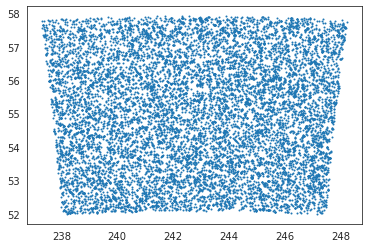

In [129]:
x = catalogue_sources['RA']
y = catalogue_sources['Dec']
plt.scatter(x,y,s=1)
plt.show()

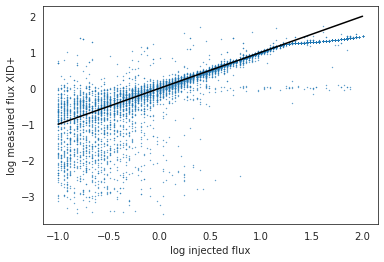

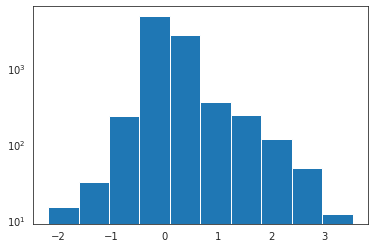

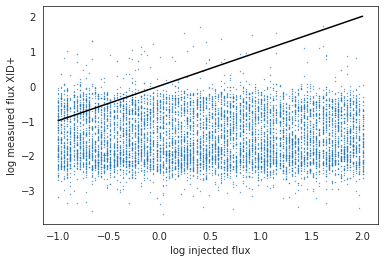

In [241]:
moc_mask = inMoc(catalogue_sources['RA'],catalogue_sources['Dec'],radim_moc)

x = catalogue_sources['flux_injected'][moc_mask]
y = np.log10(catalogue_sources['F_LOFAR_150'][moc_mask])

plt.scatter(x,y,s=0.1)
plt.plot([-1,2],[-1,2],c='black')

plt.xlabel('log injected flux')
plt.ylabel('log measured flux XID+')
plt.show()

plt.hist(x-y,log=True)
plt.show()

moc_mask = inMoc(catalogue_random_position['RA'],catalogue_random_position['Dec'],radim_moc)
x = catalogue_random_position['flux_injected'][moc_mask]
y = np.log10(catalogue_random_position['F_LOFAR_150'][moc_mask])

plt.scatter(x,y,s=0.1)
plt.plot([-1,2],[-1,2],c='black')

plt.xlabel('log injected flux')
plt.ylabel('log measured flux XID+')
plt.show()




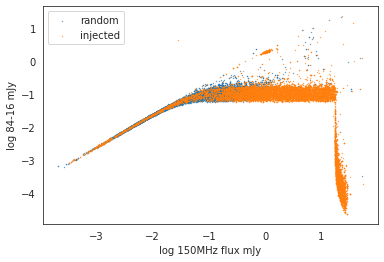

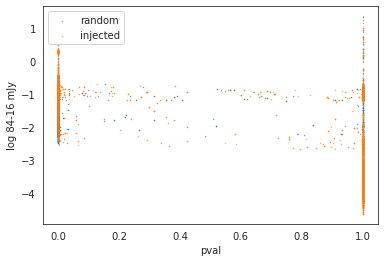

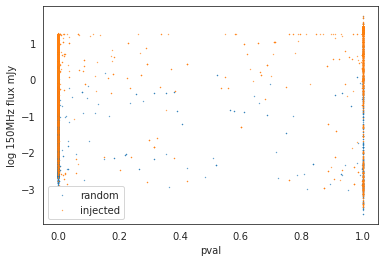

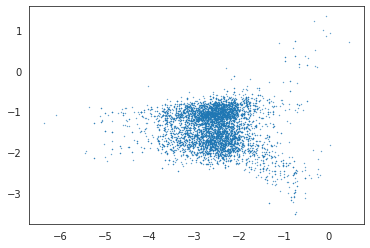

In [168]:
catalogue_merged = join(catalogue_random_position,catalogue_sources,keys='Source_Name',table_names=['random','injected'])
moc_mask = inMoc(catalogue_merged['RA_random'],catalogue_merged['Dec_random'],radim_moc)

x = np.log10(catalogue_merged['F_LOFAR_150_random'][moc_mask])
y = catalogue_merged['FErr_LOFAR_150_u_random'][moc_mask] - catalogue_merged['FErr_LOFAR_150_l_random'][moc_mask]
y = np.log10(y)
plt.scatter(x,y,s=0.1,label='random')

x = np.log10(catalogue_merged['F_LOFAR_150_injected'][moc_mask])
y = catalogue_merged['FErr_LOFAR_150_u_injected'][moc_mask] - catalogue_merged['FErr_LOFAR_150_l_injected'][moc_mask]
y = np.log10(y)
plt.scatter(x,y,s=0.1,label='injected')

plt.xlabel('log 150MHz flux mJy')
plt.ylabel('log 84-16 mJy')
plt.legend()
plt.show()


x = catalogue_merged['Pval_res_150_random'][moc_mask]
y = catalogue_merged['FErr_LOFAR_150_u_random'][moc_mask] - catalogue_merged['FErr_LOFAR_150_l_random'][moc_mask]
y = np.log10(y)
plt.scatter(x,y,s=0.1,label='random')

x = catalogue_merged['Pval_res_150_injected'][moc_mask]
y = catalogue_merged['FErr_LOFAR_150_u_injected'][moc_mask] - catalogue_merged['FErr_LOFAR_150_l_injected'][moc_mask]
y = np.log10(y)
plt.scatter(x,y,s=0.1,label='injected')

plt.xlabel('pval')
plt.ylabel('log 84-16 mJy')
plt.legend()
plt.show()


x = catalogue_merged['Pval_res_150_random'][moc_mask]
y = catalogue_merged['F_LOFAR_150_random'][moc_mask]
y = np.log10(y)
plt.scatter(x,y,s=0.1,label='random')

x = catalogue_merged['Pval_res_150_injected'][moc_mask]
y = catalogue_merged['F_LOFAR_150_injected'][moc_mask]
y = np.log10(y)
plt.scatter(x,y,s=0.1,label='injected')

plt.xlabel('pval')
plt.ylabel('log 150MHz flux mJy')
plt.legend()
plt.show()


x = np.log10(catalogue_merged['Bkg_LOFAR_150_random'][moc_mask])
y = catalogue_merged['FErr_LOFAR_150_u_random'][moc_mask] - catalogue_merged['FErr_LOFAR_150_l_random'][moc_mask]
y = np.log10(y)
plt.scatter(x,y,s=0.1,label='random')
plt.show()

In [225]:
mask = (np.log10(catalogue_merged['F_LOFAR_150_injected'])>0.4) & (catalogue_merged['Pval_res_150_injected']<0.1)
print(np.sum(mask))

file_num = catalogue_merged['Source_Name'][mask][0]


catalogue_merged[mask]

3103


Source_Name,RA_random,Dec_random,F_LOFAR_150_random,FErr_LOFAR_150_u_random,FErr_LOFAR_150_l_random,Bkg_LOFAR_150_random,Sig_conf_LOFAR_150_random,Rhat_LOFAR_150_random,n_eff_LOFAR_150_random,Pval_res_150_random,RA_injected_random,DEC_injected_random,flux_injected_random,RA_injected,Dec_injected,F_LOFAR_150_injected,FErr_LOFAR_150_u_injected,FErr_LOFAR_150_l_injected,Bkg_LOFAR_150_injected,Sig_conf_LOFAR_150_injected,Rhat_LOFAR_150_injected,n_eff_LOFAR_150_injected,Pval_res_150_injected,RA_injected_injected,DEC_injected_injected,flux_injected_injected
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,,,,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64
1099,247.01127311408806,54.69543268790412,2.3336337,2.4516902,2.2076073,0.005277903,4.90615e-06,1.0004927,2898.267,0.0,247.01127311408806,54.69543268790412,-0.696969696969697,247.01127311408806,54.69543268790412,2.532549,2.6536875,2.407301,0.00526594,4.8778056e-06,1.001491,2743.0713,0.0,247.01127311408806,54.69543268790412,-0.696969696969697
2213,240.3968957624682,56.59925466707597,2.2212412,2.442286,1.9958767,-0.012223199,5.0159333e-06,1.0019393,2218.3372,0.0,240.3968957624682,56.59925466707597,-0.33333333333333326,240.3968957624682,56.59925466707597,2.6852458,2.906025,2.4593575,-0.012243738,5.0671542e-06,1.0008672,1856.1791,0.0,240.3968957624682,56.59925466707597,-0.33333333333333326
2362,240.10635785901667,53.686971211163176,2.243462,2.5610843,1.9236207,0.017240625,4.889853e-06,1.0012177,2415.81,0.0,240.10635785901667,53.686971211163176,-0.303030303030303,240.10635785901667,53.686971211163176,2.7547896,3.0610433,2.4415858,0.017198447,4.891952e-06,1.0003273,2307.367,0.0,240.10635785901667,53.686971211163176,-0.303030303030303
2453,245.29933221029418,52.9052673015649,10.439614,10.7282915,10.159563,0.13440531,4.920117e-06,1.0003328,3582.5254,1.0,245.29933221029418,52.9052673015649,-0.2727272727272727,245.29933221029418,52.9052673015649,6.268463,6.6437607,5.9038863,0.007834371,4.9780574e-06,1.0001593,3014.0532,0.0,245.29933221029418,52.9052673015649,-0.2727272727272727
2453,245.29933221029418,52.9052673015649,5.7472687,6.12026,5.387003,0.007813783,4.952566e-06,1.0003276,2784.337,0.0,245.29933221029418,52.9052673015649,-0.2727272727272727,245.29933221029418,52.9052673015649,6.268463,6.6437607,5.9038863,0.007834371,4.9780574e-06,1.0001593,3014.0532,0.0,245.29933221029418,52.9052673015649,-0.2727272727272727
2484,245.5314469673659,57.25859658524747,0.07665752,0.16844231,0.021992391,0.007595322,4.981671e-06,1.0001969,2554.1726,0.0,245.5314469673659,57.25859658524747,-0.2727272727272727,245.5314469673659,57.25859658524747,3.363151,4.4290447,2.327934,-0.019559722,5.0713033e-06,0.99978,2815.65,0.0,245.5314469673659,57.25859658524747,-0.2727272727272727
2648,243.78521417296054,55.784050166351435,5.0216413,5.608647,4.420173,-0.00812786,4.983634e-06,0.9996838,3178.0042,0.0,243.78521417296054,55.784050166351435,-0.21212121212121215,243.78521417296054,55.784050166351435,5.61996,6.2151375,5.0278754,-0.0082196435,5.034607e-06,0.99972576,3537.5725,0.0,243.78521417296054,55.784050166351435,-0.21212121212121215
2692,242.64090005420329,52.60967167116877,3.1300204,3.3375306,2.9164758,0.015016297,4.953474e-06,1.0015721,1901.8552,0.0,242.64090005420329,52.60967167116877,-0.21212121212121215,242.64090005420329,52.60967167116877,3.7435734,3.9448254,3.5316684,0.015054117,4.922108e-06,1.0006034,1782.9227,0.0,242.64090005420329,52.60967167116877,-0.21212121212121215


In [232]:
10**-0.7

0.19952623149688797

In [227]:
filename = 'data/xidplus_results/random_positions/xidplus_run_{}/random_positions_{}.pkl.pkl'.format(file_num,file_num)
prior,posterior = xidplus.load(filename)
prior = prior[0]

In [228]:
prior.prior_flux_upper

array([ 15.36911416, 215.63813782])

In [233]:
prior.ID

array(['1099', 'ILTJ162808.21+544122.1'], dtype='<U22')

In [208]:
prior.sra

array([241.09354595, 241.11261609])

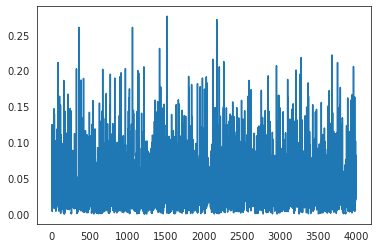

In [209]:
y = posterior.samples['src_f'][:,0,1]
plt.plot(y)

([<aplpy.core.FITSFigure at 0x2aad5ffa1090>],
 <Figure size 720x720 with 2 Axes>)

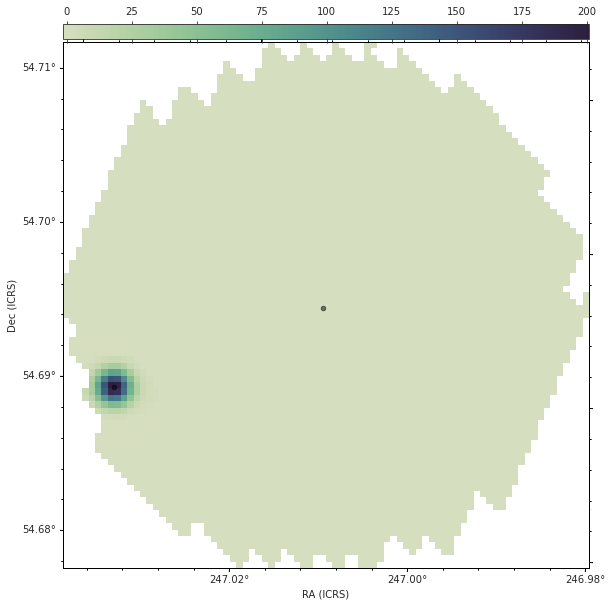

In [235]:
xidplus.plot_map([prior])

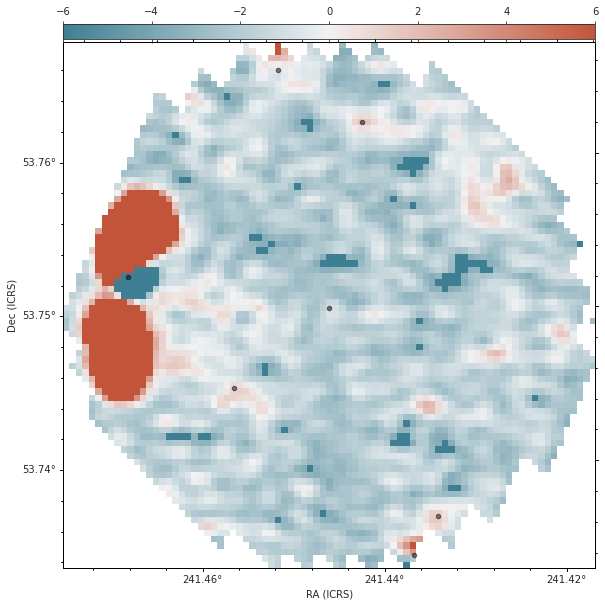

In [191]:
figs,fig=xidplus.plot_Bayes_pval_map([prior], posterior)

In [229]:
filename = 'data/xidplus_results/injected_sources/xidplus_run_{}/injected_sources_{}.pkl.pkl'.format(file_num,file_num)
prior,posterior = xidplus.load(filename)
prior = prior[0]

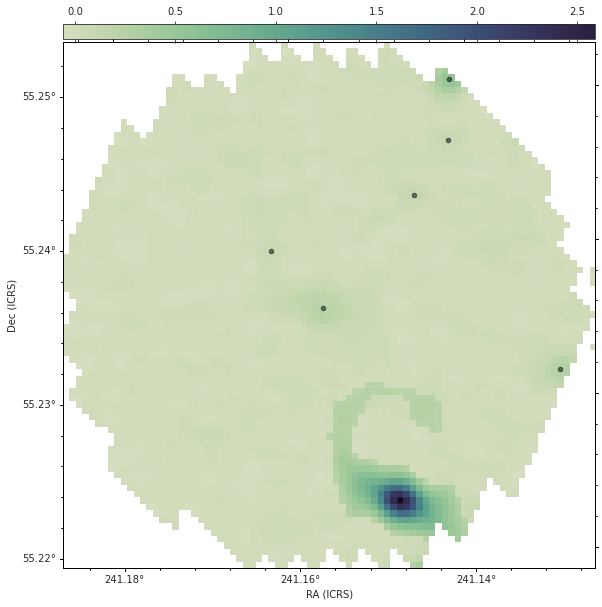

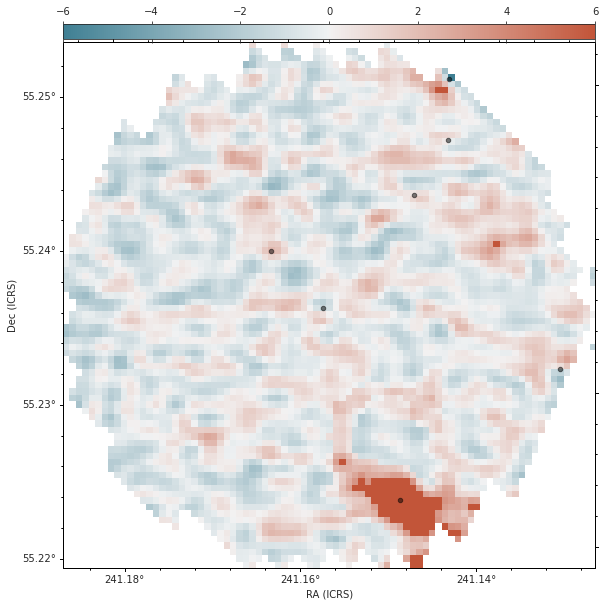

In [182]:
xidplus.plot_map([prior])
plt.show()
figs,fig=xidplus.plot_Bayes_pval_map([prior], posterior)
plt.show()

(array([  35.,  133.,  421.,  829., 1069.,  890.,  432.,  161.,   25.,
           5.]),
 array([2.1484487, 2.2328432, 2.3172376, 2.401632 , 2.4860265, 2.5704207,
        2.6548152, 2.7392097, 2.823604 , 2.9079986, 2.992393 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

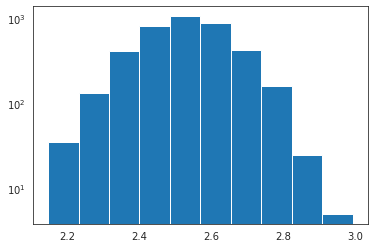

In [234]:
y = posterior.samples['src_f'][:,0,0]
plt.hist(y,log=True)

(array([  35.,  133.,  421.,  829., 1069.,  890.,  432.,  161.,   25.,
           5.]),
 array([2.1484487, 2.2328432, 2.3172376, 2.401632 , 2.4860265, 2.5704207,
        2.6548152, 2.7392097, 2.823604 , 2.9079986, 2.992393 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

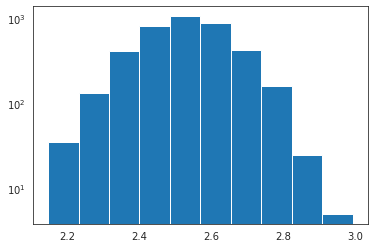

In [231]:
y = posterior.samples['src_f'][:,0,0]
plt.hist(y,log=True)

In [230]:
prior.prior_flux_upper

array([ 15.39230636, 215.63813782])